# **Finance Pairs Formation**

# **Import libraries and dataset**

In [1]:
import numpy as np
import pandas as pd
import statsmodels
from statsmodels.tsa.stattools import coint, adfuller
import statistics as stats
import plotly.graph_objects as go
import missingno as msno
import plotly.express as px
import plotly.figure_factory as ff
import itertools
from heapq import nsmallest, nlargest
import matplotlib.pyplot as plt
import seaborn as sns
import more_itertools
from statsmodels.tsa.vector_ar.vecm import coint_johansen
import statsmodels.api as sm

sns.set(rc={'figure.figsize':(20,14)})

In [2]:
import sys
# locate the folder which stores the custom package using relative path
sys.path.append('../../../../../src')

import config_snippets as config_snp
import splitting_data as splitting_data
import gatev_distance_method as gatev_dist
import data_transformation_snippets as data_transform_snp
import time_series_analysis_snippets as tsa_snp
import engle_granger_cointegration_method as eg_coint
import johansen_cointegration_method as jj_coint 
import handling_dataframe as hdf
import handling_datetime as hdt

In [3]:
# Path to your config YAML file
config_file_path = "..//..//../config.yaml"

# Load the configuration
config = config_snp.load_config(config_file_path)

if config is not None:
    import ast
    # Access and use the parameters
    split_ratio = config.get("split_ratio")
    
    # Access and convert string to tuple
    train_period = ast.literal_eval(config.get("train_period"))
    test_period = ast.literal_eval(config.get("test_period"))
    
    # Get list of df_tech data paths
    lst_df_tech_paths = ast.literal_eval(config.get("paths_df_tech_processed"))
    

In [4]:
# Import data 
path = lst_df_tech_paths[1]
df = pd.read_csv(path)

In [5]:
# Set date as index
df.set_index("date", inplace=True)

In [6]:
df = df.dropna()

# **Split data**

In [7]:
# Example: split ratio = 0.7
df_train, df_test = splitting_data.splitting_data_by_ratio(
    df,
    split_ratio=split_ratio
)

In [8]:
# Example of splitting by specified period

# test_train, test_test = splitting_data_by_date(
#     df,
#     train_period = train_period,
#     test_period = test_period
# )

# **Gatev Distance Approach**

In [9]:
df_train

,adClose_CMG,adClose_ELC,adClose_FPT,adClose_ITD,adClose_PSD,adClose_SAM,adClose_SGT,adClose_SRA,adClose_ST8,adClose_TYA
date,,,,,,,,,,
2020-04-13,17.148,3.686,22.955,5.794,6.612,8.249,2.755,5.017,7.848,9.003
2020-04-14,17.407,3.686,24.436,5.816,6.282,8.222,2.824,4.955,7.316,8.896
2020-04-15,17.925,3.842,24.732,6.080,6.282,8.222,2.686,5.326,7.316,9.003
2020-04-16,18.604,3.850,24.831,6.358,6.282,8.239,2.789,5.450,7.316,8.896
2020-04-17,19.090,4.014,25.275,6.351,6.612,8.284,2.893,5.450,7.348,9.040
...,...,...,...,...,...,...,...,...,...,...
2021-05-20,23.799,9.830,56.409,10.471,10.985,9.201,11.708,8.000,7.837,13.381
2021-05-21,23.433,9.994,55.405,10.918,11.126,9.303,11.019,8.100,7.837,13.503
2021-05-22,23.433,9.994,55.405,10.918,11.126,9.303,11.019,8.100,7.837,13.503


## **Gatev Data Normalization**

In [10]:
df_cum_daily_returns_train = gatev_dist.gatev_data_normalize(df_train)

In [11]:
df_cum_daily_returns_train

,adClose_CMG,adClose_ELC,adClose_FPT,adClose_ITD,adClose_PSD,adClose_SAM,adClose_SGT,adClose_SRA,adClose_ST8,adClose_TYA
date,,,,,,,,,,
2020-04-14,1.510380,0.000000,6.451753,0.379703,-4.990926,-0.327312,2.504537,-1.235798,-6.778797,-1.188493e+00
2020-04-15,4.531141,4.232230,7.741233,4.936141,-4.990926,-0.327312,-2.504537,6.159059,-6.778797,2.220446e-14
2020-04-16,8.490786,4.449267,8.172511,9.734208,-4.990926,-0.121227,1.234120,8.630656,-6.778797,-1.188493e+00
2020-04-17,11.324936,8.898535,10.106731,9.613393,0.000000,0.424294,5.009074,8.630656,-6.371050,4.109741e-01
2020-04-18,11.324936,8.898535,10.106731,9.613393,0.000000,0.424294,5.009074,8.630656,-6.371050,4.109741e-01
...,...,...,...,...,...,...,...,...,...,...
2021-05-20,38.785864,166.684753,145.737312,80.721436,66.137326,11.540793,324.972777,59.457843,-0.140163,4.862824e+01
2021-05-21,36.651505,171.134021,141.363537,88.436313,68.269812,12.777306,299.963702,61.451066,-0.140163,4.998334e+01
2021-05-22,36.651505,171.134021,141.363537,88.436313,68.269812,12.777306,299.963702,61.451066,-0.140163,4.998334e+01


## **Gatev Distance Approach Pairs Formation**

In [12]:
gatev_dist.gatev_distance_matrix(df_cum_daily_returns_train)

In [13]:
gatev_pairs, list_result_smallest_dist = gatev_dist.gatev_distance_smallest(
    df=df_cum_daily_returns_train,
    top_values=10
)

In [14]:
for res in list_result_smallest_dist:
    print(res)
    
print(gatev_pairs)

Khoảng cách Euclide của adClose_CMG và adClose_ITD: 447.6
Khoảng cách Euclide của adClose_CMG và adClose_SAM: 324.1
Khoảng cách Euclide của adClose_CMG và adClose_TYA: 209.8
Khoảng cách Euclide của adClose_FPT và adClose_ITD: 378.9
Khoảng cách Euclide của adClose_FPT và adClose_PSD: 488.9
Khoảng cách Euclide của adClose_ITD và adClose_PSD: 389.2
Khoảng cách Euclide của adClose_ITD và adClose_TYA: 331.4
Khoảng cách Euclide của adClose_PSD và adClose_TYA: 529.5
Khoảng cách Euclide của adClose_SAM và adClose_ST8: 535.9
Khoảng cách Euclide của adClose_SAM và adClose_TYA: 356.9
[['adClose_CMG', 'adClose_ITD'], ['adClose_CMG', 'adClose_SAM'], ['adClose_CMG', 'adClose_TYA'], ['adClose_FPT', 'adClose_ITD'], ['adClose_FPT', 'adClose_PSD'], ['adClose_ITD', 'adClose_PSD'], ['adClose_ITD', 'adClose_TYA'], ['adClose_PSD', 'adClose_TYA'], ['adClose_SAM', 'adClose_ST8'], ['adClose_SAM', 'adClose_TYA']]


In [15]:
gatev_pairs

[['adClose_CMG', 'adClose_ITD'],
 ['adClose_CMG', 'adClose_SAM'],
 ['adClose_CMG', 'adClose_TYA'],
 ['adClose_FPT', 'adClose_ITD'],
 ['adClose_FPT', 'adClose_PSD'],
 ['adClose_ITD', 'adClose_PSD'],
 ['adClose_ITD', 'adClose_TYA'],
 ['adClose_PSD', 'adClose_TYA'],
 ['adClose_SAM', 'adClose_ST8'],
 ['adClose_SAM', 'adClose_TYA']]

# **Cointegration Approach**

## **Data Transformation**

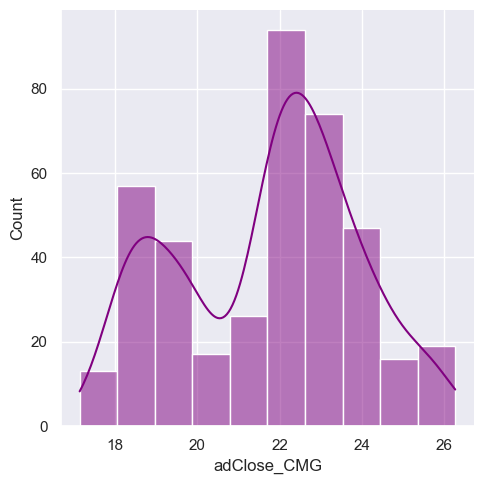

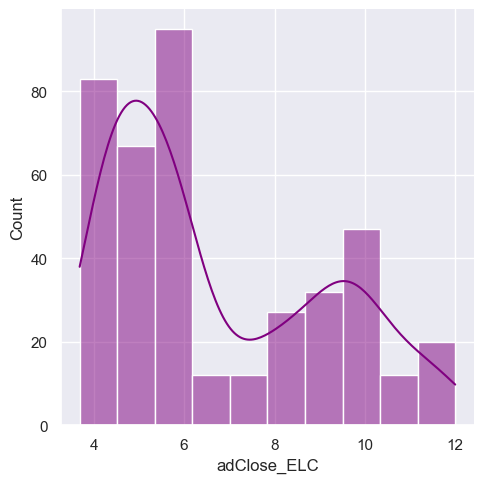

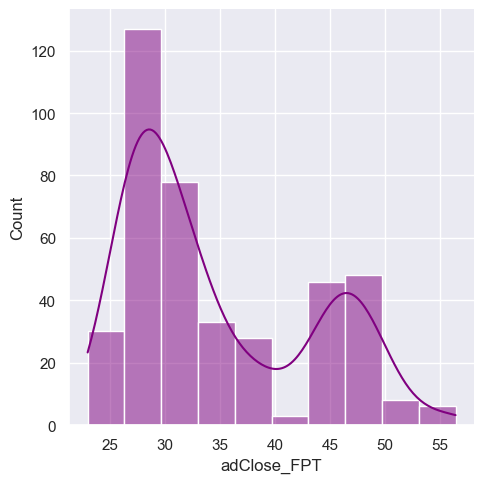

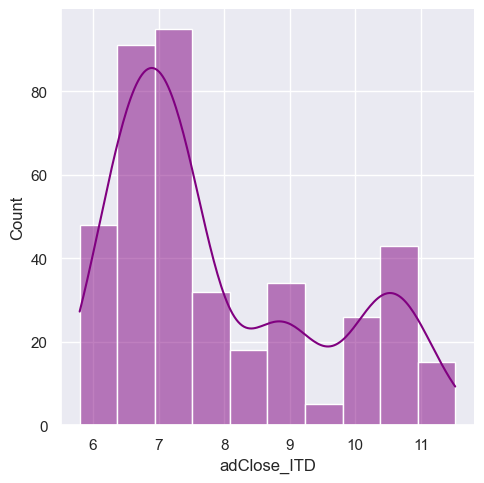

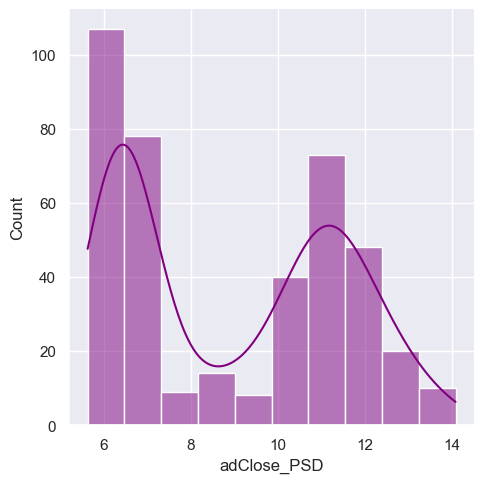

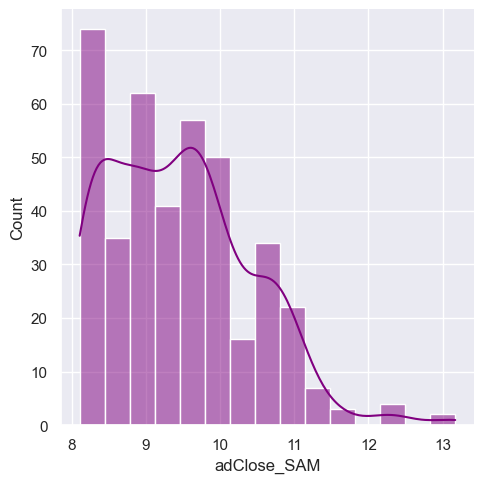

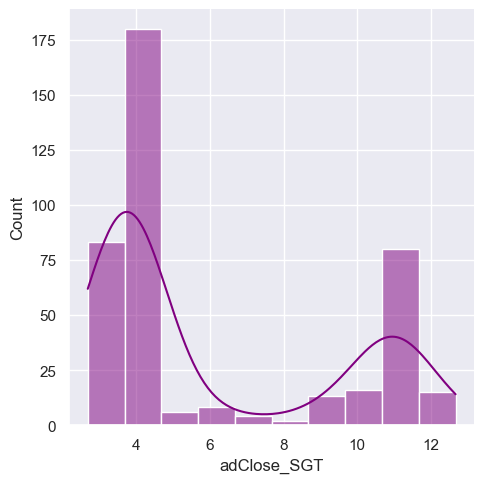

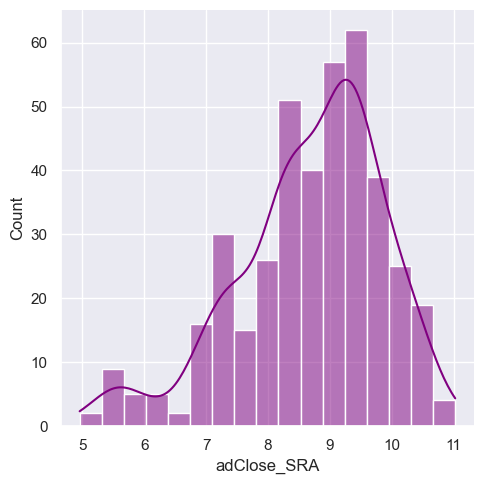

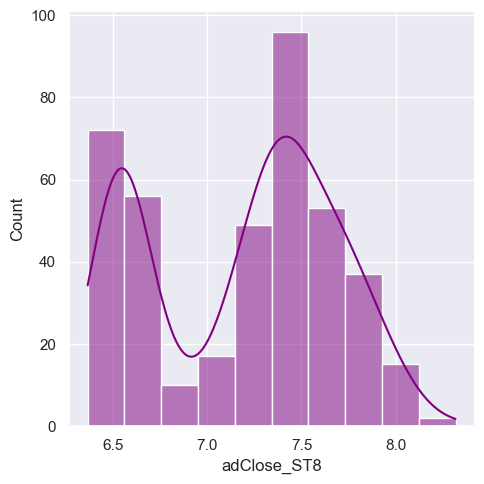

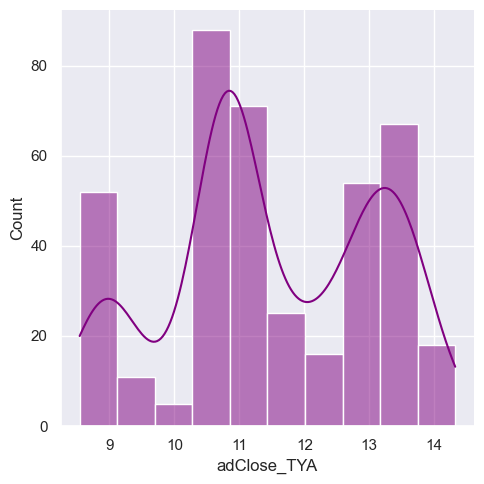

In [16]:
# Visualize distribution of values of each stock
data_transform_snp.dist_stock_visualization(df_train)

In [17]:
# Take natural log transformation of the data  
df_train_transformed = data_transform_snp.df_natural_log_transformed(df_train)

In [18]:
# Visualize distribution of transformed values of each stock
data_transform_snp.dist_stock_visualization(df_train_transformed)

## **Pretesting Stationary**

In [19]:
tsa_snp.find_integration_order(df_train_transformed)

,Column Name,Integration Order
0,adClose_CMG,1
1,adClose_ELC,1
2,adClose_FPT,1
3,adClose_ITD,1
4,adClose_PSD,1
5,adClose_SAM,1
6,adClose_SGT,1
7,adClose_SRA,0
8,adClose_ST8,1
9,adClose_TYA,1


## **Engle - Grange Method**

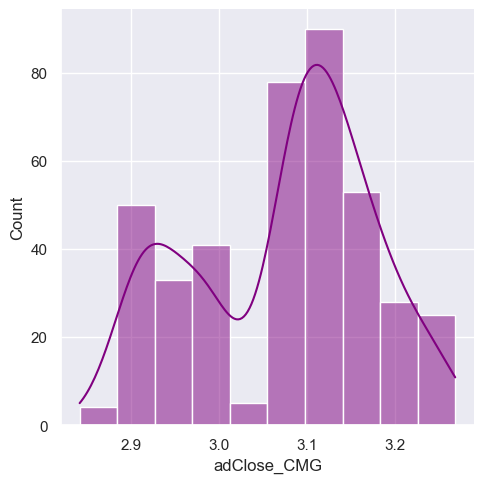

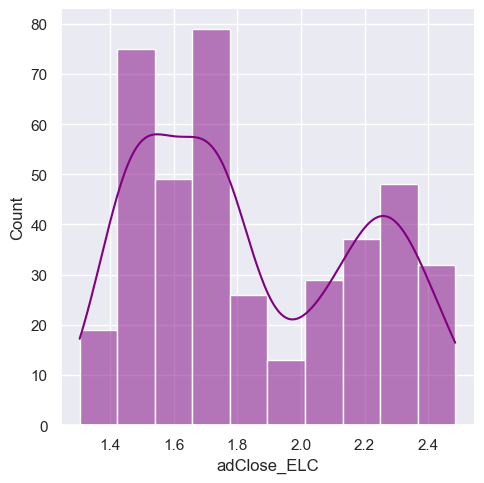

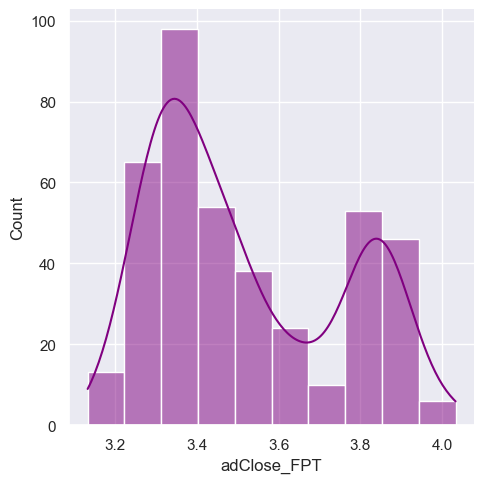

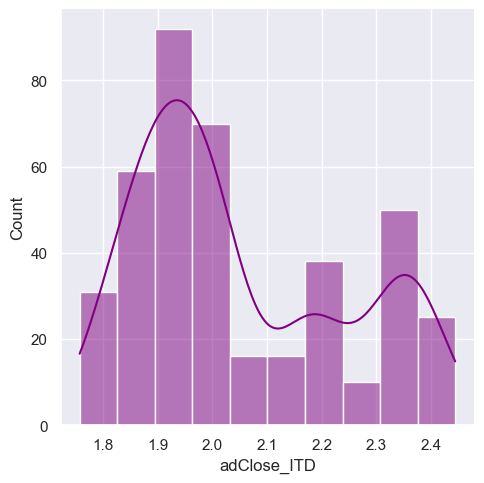

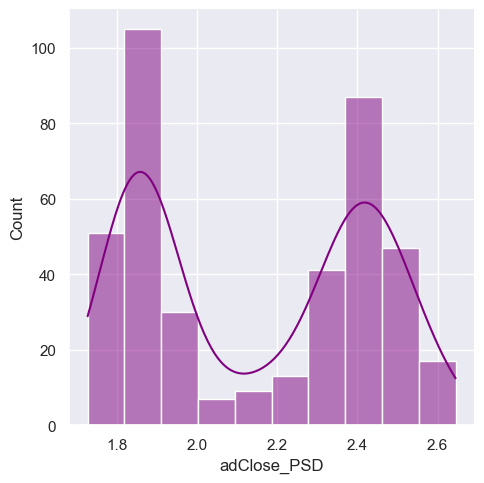

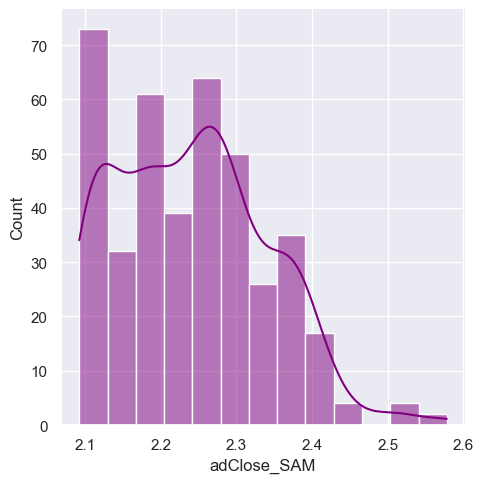

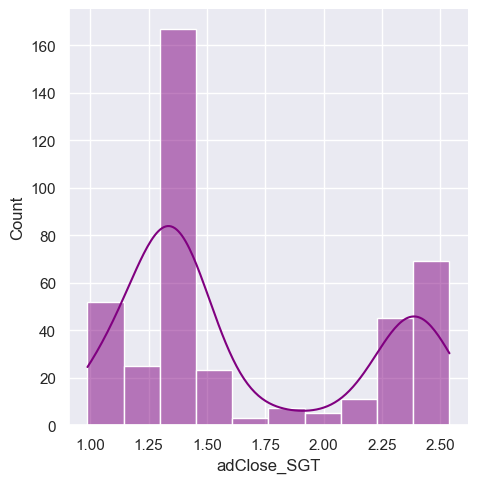

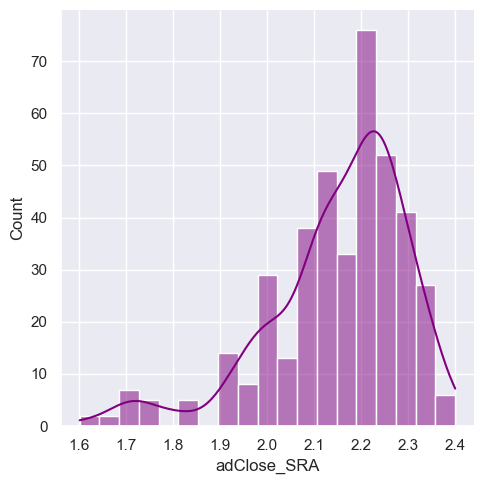

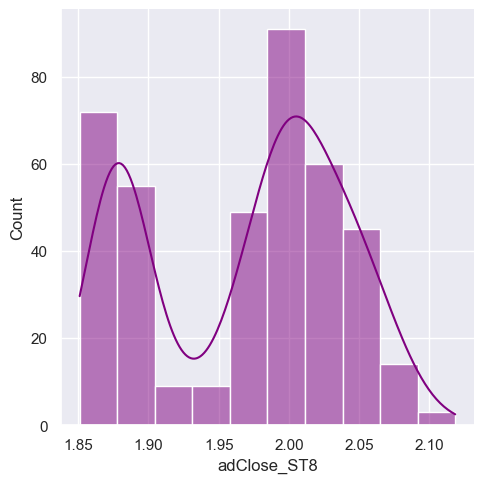

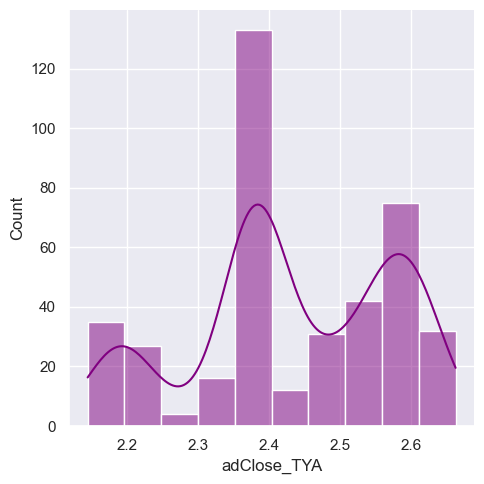

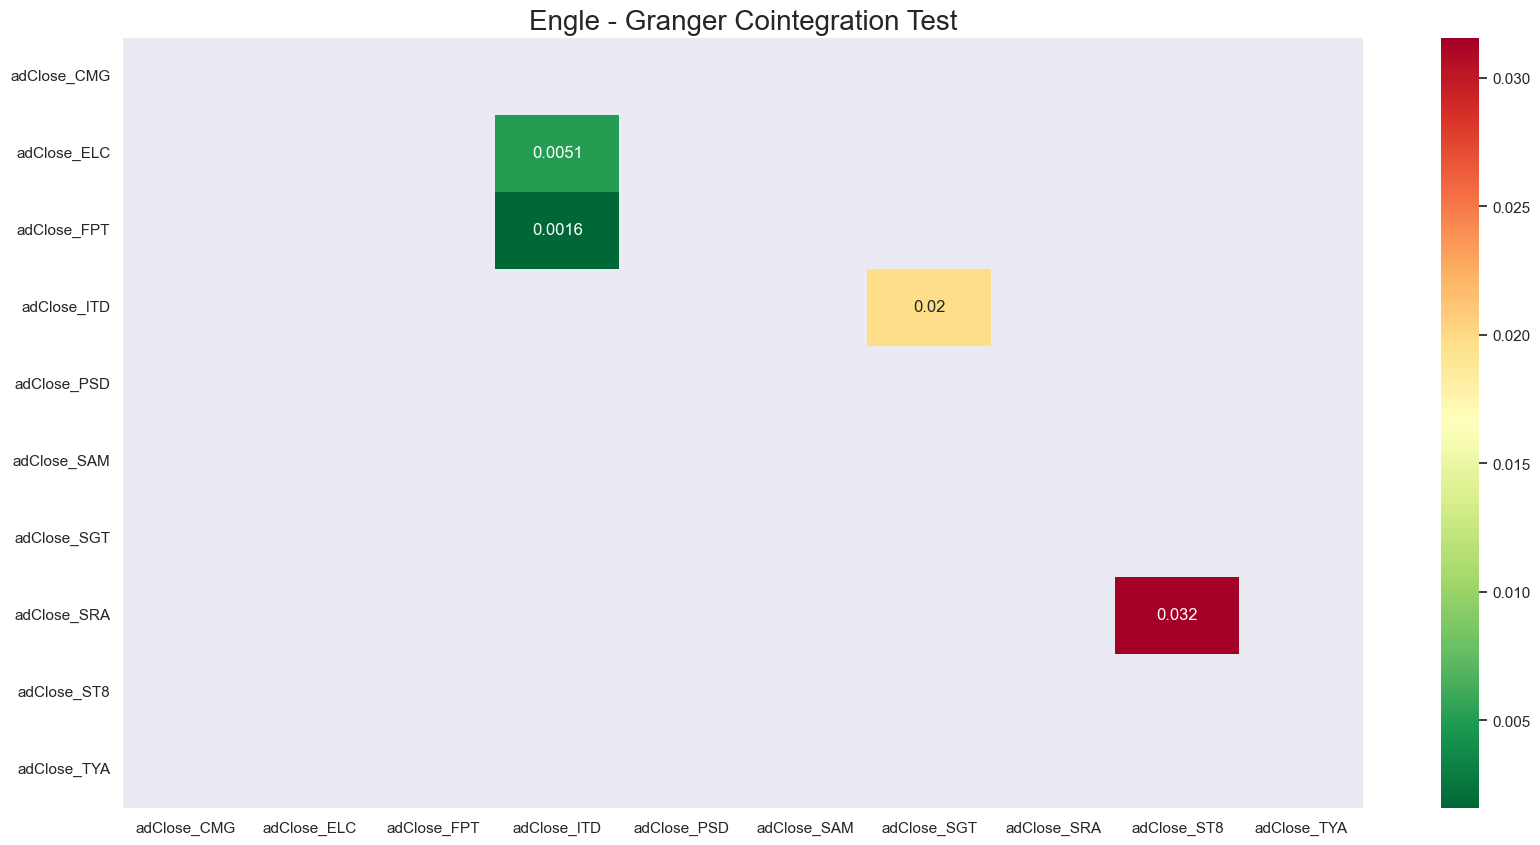

In [20]:
score_matrix, pvalue_matrix, eg_pairs = eg_coint.find_cointegrated_pairs(df_train_transformed)

In [21]:
eg_pairs 

[['adClose_ELC', 'adClose_ITD'],
 ['adClose_FPT', 'adClose_ITD'],
 ['adClose_ITD', 'adClose_SGT'],
 ['adClose_SRA', 'adClose_ST8']]

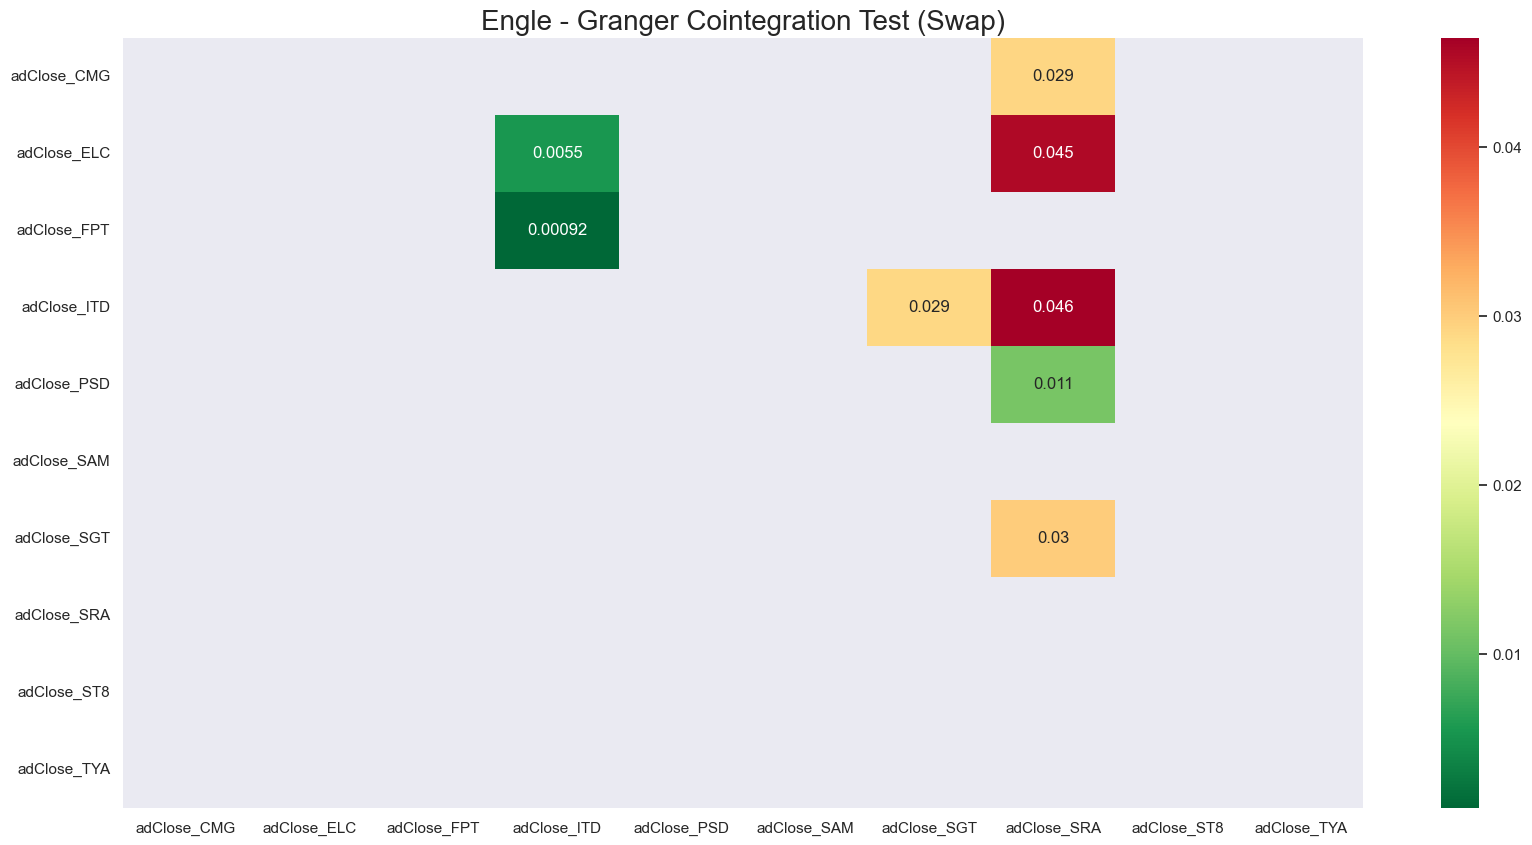

In [22]:
scores_swap, pvalues_swap, eg_pairs_swap = eg_coint.find_cointegrated_pairs_swap(df_train_transformed)

In [23]:
eg_pairs_swap

[['adClose_CMG', 'adClose_SRA'],
 ['adClose_ELC', 'adClose_ITD'],
 ['adClose_ELC', 'adClose_SRA'],
 ['adClose_FPT', 'adClose_ITD'],
 ['adClose_ITD', 'adClose_SGT'],
 ['adClose_ITD', 'adClose_SRA'],
 ['adClose_PSD', 'adClose_SRA'],
 ['adClose_SGT', 'adClose_SRA']]

## **Johansen Method**

In [24]:
johansen_pairs = jj_coint.johansen_test(df_train_transformed)

In [25]:
johansen_pairs

[['adClose_CMG', 'adClose_SRA'],
 ['adClose_ELC', 'adClose_ITD'],
 ['adClose_ELC', 'adClose_SGT'],
 ['adClose_FPT', 'adClose_ITD'],
 ['adClose_PSD', 'adClose_SRA'],
 ['adClose_SAM', 'adClose_SRA'],
 ['adClose_SGT', 'adClose_SRA'],
 ['adClose_SRA', 'adClose_ST8'],
 ['adClose_SRA', 'adClose_TYA']]

# **Result Summary**

In [26]:
df_pairs_formation_train = hdf.pairs_formation_result_summary(
    gatev_pairs,
    eg_pairs,
    eg_pairs_swap,
    johansen_pairs
)

In [28]:
df_pairs_formation_train

,Stock A,Stock B,Gatev Pairs,EG Pairs,EG Pairs Swap,Johansen Pairs,Count
0,adClose_CMG,adClose_ITD,x,,,,1
1,adClose_CMG,adClose_SAM,x,,,,1
2,adClose_CMG,adClose_SRA,,,x,x,2
3,adClose_CMG,adClose_TYA,x,,,,1
4,adClose_ELC,adClose_ITD,,x,x,x,3
5,adClose_ELC,adClose_SGT,,,,x,1
6,adClose_ELC,adClose_SRA,,,x,,1
7,adClose_FPT,adClose_ITD,x,x,x,x,4
8,adClose_FPT,adClose_PSD,x,,,,1
9,adClose_ITD,adClose_PSD,x,,,,1


In [29]:
df_pairs_formation_train.to_csv(
    f"..//..//..//..//..//results//pairs_formation//tech//tech_pairs_formation_second_period_{hdt.today_date_to_digits()}.csv"
    )